In [1]:
import pandas as pd
import numpy as np
from time import time
from data.data import load_data
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# TODO fill this cell out

# Give this run a title
run = 'convnet+nasnet_15+recnn_15_aug'

# Add validation files
capsnet_val = pd.read_csv('./ensemble/validation_capsnet_15epoch_aug.csv')
capsnet_bn_val = pd.read_csv('./ensemble/validation_capsnet_bn_15epochs.csv')
convnet_val = pd.read_csv('./ensemble/validation_convnet_augmentation (2).csv')
nasnet_val = pd.read_csv('./ensemble/validation_Nasnet_15epoch_aug.csv')
recnn_val = pd.read_csv('./ensemble/validation_recnn_15epoch_aug_regenerated.csv')
#datas = [capsnet_val, capsnet_bn_val, convnet_val, nasnet_val, recnn_val]
datas = [convnet_val, nasnet_val, recnn_val]

# Add test files
capsnet_test = pd.read_csv('./ensemble/test_capsnet_15epoch_aug.csv')
capsnet_bn_test = pd.read_csv('./ensemble/test_capsnet_bn_15epochs.csv')
convnet_test = pd.read_csv('./ensemble/test_convnet_augmentation (2).csv')
nasnet_test = pd.read_csv('./ensemble/test_Nasnet_15epoch_aug.csv')
recnn_test = pd.read_csv('./ensemble/test_recnn_15epoch_aug_regenerated.csv')
#tests = [capsnet_test, capsnet_bn_test, convnet_test, nasnet_test, recnn_test]
tests = [convnet_test, nasnet_test, recnn_test]

In [3]:
# Create x and y datasets
x_total_train = np.stack(([x['prediction'] for x in datas]), axis=1)
_, (_, y_pred_val, _), _ = load_data()
y_total_train = np.ravel(y_pred_val)
x_train, x_valid, y_train, y_valid = train_test_split(x_total_train, y_total_train)

# Create x testset
x_test = np.stack(([x['prediction'] for x in tests]), axis=1)

In [9]:
# Correlation matrix on validation files
predictions = {'convnet_val': convnet_val['prediction'],
              'nasnet_val': nasnet_val['prediction'],
              'recnn_val': recnn_val['prediction']}
df_predictions = pd.DataFrame(data=predictions) 
df_predictions.corr()

,convnet_val,nasnet_val,recnn_val
convnet_val,1.000000,0.268389,0.274908
nasnet_val,0.268389,1.000000,0.869997
recnn_val,0.274908,0.869997,1.000000


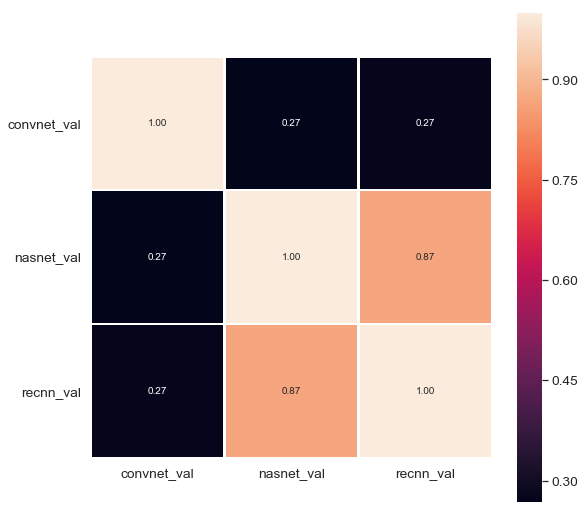

In [10]:
# Plot validation correlations
plt.figure(figsize=(9, 9))
sns.set(font_scale=1.25)
sns.heatmap(df_predictions.corr(), linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=df_predictions.columns , xticklabels=df_predictions.columns
            )
plt.yticks(rotation=0)
plt.show()

In [11]:
# Correlation matrix on test files
predictions = {'convnet_test': convnet_test['prediction'],
              'nasnet_test': nasnet_test['prediction'],
              'recnn_test': recnn_test['prediction']}
df_predictions = pd.DataFrame(data=predictions) 
df_predictions.corr()

,convnet_test,nasnet_test,recnn_test
convnet_test,1.000000,0.835652,0.867552
nasnet_test,0.835652,1.000000,0.853192
recnn_test,0.867552,0.853192,1.000000


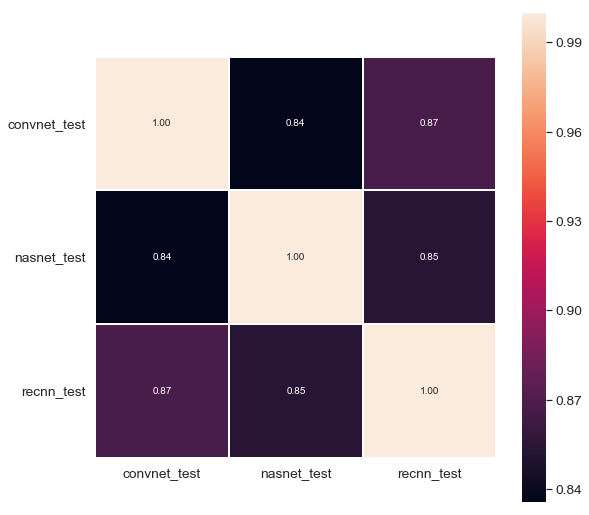

In [12]:
# Plot correlations
plt.figure(figsize=(9, 9))
sns.set(font_scale=1.25)
sns.heatmap(df_predictions.corr(), linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=df_predictions.columns , xticklabels=df_predictions.columns
            )
plt.yticks(rotation=0)
plt.show()

In [13]:
# Parameter tuning
xg_model = XGBClassifier(n_estimators=100, seed = 1234)
param_dict = {'max_depth': [3,4,5,6,8],
              'min_child_weight': [1,2,3],
              'learning_rate': [0.1,0.15,0.2,0.25],
              'gamma': [0, 0.1, 0.2]
}

start = time()
grid_search = GridSearchCV(xg_model, param_dict, cv=5, verbose=10, n_jobs=4)
grid_search.fit(x_train, y_train)
print("GridSearch took %.2f seconds to complete." % (time()-start))
display(grid_search.best_params_)
best = grid_search.best_params_

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    6.2s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.4s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   16.8s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   22.8s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   29.6s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:   36.9s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:   41.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:   47.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   53.9s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:  1.3min
[Parallel(

KeyboardInterrupt: 

In [25]:
# Fitting the model

#best_no_conv = {'gamma': 0.2, 'learning_rate': 0.15, 'max_depth': 10, 'min_child_weight': 1}
#best_with_conv = {'gamma': 0, 'learning_rate': 0.25, 'max_depth': 4, 'min_child_weight': 1}
#best_conv_res_caps = 

xg_model = XGBClassifier(n_estimators = 1000,
                        learning_rate = best['learning_rate'],
                        max_depth = best['max_depth'],
                        min_child_weight = best['min_child_weight'],
                        gamma = best['gamma'],
                        seed = 1234)
start = time()
xg_model.fit(x_train, y_train)
xg_preds = xg_model.predict(x_valid)
print("Model took %.2f seconds to complete." % (time()-start))
print("Validation accuracy: %.4f" % accuracy_score(y_valid, xg_preds))

Model took 11.51 seconds to complete.
Validation accuracy: 0.9180


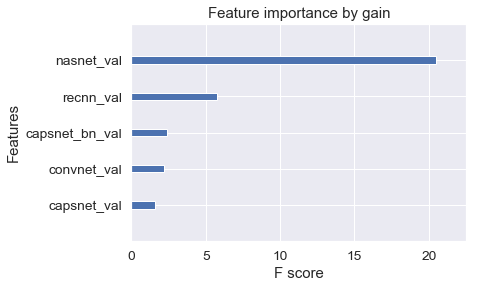

In [28]:
# Most important features (models)
xg_model.get_booster().feature_names = ["convnet_val","nasnet_val", "recnn_val"]
plot_importance(xg_model, importance_type='gain', show_values=False, title='Feature importance by gain')
plt.show()

In [30]:
# Train on whole dataset
xg_model_total = XGBClassifier(n_estimators = 1000,
                        learning_rate = best['learning_rate'],
                        max_depth = best['max_depth'],
                        min_child_weight = best['min_child_weight'],
                        gamma = best['gamma'],
                        seed = 1234)
xg_model_total.fit(x_total_train, y_total_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.25,
       max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1234, silent=None,
       subsample=1, verbosity=1)

In [31]:
# Predict on model
xg_preds = xg_model_total.predict_proba(x_test)
data = {'case': np.arange(xg_preds.shape[0]), 'prediction': np.ravel(xg_preds[:,1])}
submission = pd.DataFrame(data=data)
submission.to_csv('./predictions/test_xgboost_{}.csv'.format(run), index=False)